In [1]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
from captum.attr import LayerConductance, LayerIntegratedGradients
from fairseq.data.data_utils import load_indexed_dataset
from sklearn.linear_model import ridge_regression
from captum.attr import visualization as viz
from fairseq.models.bart import BARTModel
from fairseq.data import Dictionary
from tqdm import tqdm
import pandas as pd
import numpy as np
import pandas as pd
import argparse
import torch
import json
import os
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit import Chem
import torch


/home/gayane/miniconda3/envs/cptm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-17 17:08:54 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2022-06-17 17:08:56 | INFO | rdkit | Enabling RDKit 2021.09.5 jupyter extensions


In [3]:
dataset_name = 'clintox_0'
# dataset = dataset_name if dataset_name in set(["BBBP", "BACE", "HIV"]) else f"{dataset_name}_{args.subtask}"
dataset = dataset_name

store_path = "/home/gayane/BartLM/Bart/chemical/checkpoints/evaluation_data"
model = f"{store_path}/{dataset}/processed"

with open('/home/gayane/BartLM/captum/fairseq/scripts/datasets.json') as f:
    datasets_json = json.load(f)
dataset_js = datasets_json[dataset]
task_type = dataset_js['type']

if task_type == "regression":
    mi = dataset_js['minimum']
    ma = dataset_js['maximum']

os.system(f"mkdir -p {store_path}/{dataset}/")
os.system(f"mkdir -p {store_path}/{dataset}/processed/")
os.system(f"mkdir -p {store_path}/{dataset}/processed/input0/")
os.system(f"mkdir -p {store_path}/{dataset}/processed/label/")

warmup = 77
totNumUpdate = 482
lr = '3e-5'
chkpt_path = '/mnt/good/gayane/data/chkpt/clintox_0_bs_16_lr_3e-5_totalNum_739_warmup_118/checkpoint_best.pt'
# chkpt_path = f"/mnt/good/gayane/data/chkpt/{dataset}_bs_16_lr_{lr}_totalNum_{totNumUpdate}_warmup_{warmup}/checkpoint_last.pt"
print(chkpt_path)  # BACE_bs_16_lr_3e-5_totalNum_1135_warmup_181/ in test 
bart = BARTModel.from_pretrained(model,  checkpoint_file = chkpt_path, 
                                 bpe="sentencepiece",
                                 sentencepiece_model="/home/gayane/BartLM/Bart/chemical/tokenizer/chem.model")
bart.eval()
bart.cuda(device=1)


2022-06-17 17:09:00 | INFO | fairseq.file_utils | loading archive file /home/gayane/BartLM/Bart/chemical/checkpoints/evaluation_data/clintox_0/processed


/mnt/good/gayane/data/chkpt/clintox_0_bs_16_lr_3e-5_totalNum_739_warmup_118/checkpoint_best.pt


OSError: Model file not found: /mnt/good/gayane/data/chkpt/clintox_0_bs_16_lr_3e-5_totalNum_739_warmup_118/checkpoint_best.pt

In [3]:

input_dict = Dictionary.load(f"{store_path}/{dataset}/processed/input0/dict.txt")
smiles = list(load_indexed_dataset(
    f"{store_path}/{dataset}/processed/input0/valid", input_dict))

2022-05-13 15:03:03 | INFO | fairseq.data.data_utils | loaded 1,182 examples from: /home/gayane/BartLM/Bart/chemical/checkpoints/evaluation_data/clintox_0/processed/input0/valid


In [4]:
test_label_path = f"{store_path}/{dataset}/processed/label/valid"

if task_type == 'classification':
    
    target_dict = Dictionary.load(f"{store_path}/{dataset}/processed/label/dict.txt")
    targets = list(load_indexed_dataset(test_label_path, target_dict))
elif task_type == 'regression':
    with open(f'{test_label_path}.label') as f:
        lines = f.readlines()
        targets = [float(x.strip()) for x in lines]

2022-05-13 15:03:03 | INFO | fairseq.data.data_utils | loaded 148 examples from: /home/gayane/BartLM/Bart/chemical/checkpoints/evaluation_data/clintox_0/processed/label/valid


In [5]:
y_pred =[]
y = []

In [6]:
# for i, (smile, target) in tqdm(list(enumerate(zip(smiles, targets)))):
#         smile = torch.cat((torch.cat((torch.tensor([0]), smile[:126])), torch.tensor([2])))  
#         if task_type =="classification":
#             output = bart.predict('sentence_classification_head', smile)
#             target = target[0].item()
#             y_pred.append(output[0][1].exp().item())
#             y.append(target - 4)
            
#         elif task_type == "regression":
#             output = bart.predict('sentence_classification_head', smile, return_logits=True)
#             y_pred.append(output[0][0].item())
#             y.append(target)

In [7]:
# len(y_pred), len(y), len(list(enumerate(zip(smiles, targets))))

In [8]:
def bart_forward(smile, **kwargs):
#     print('inside', smile.size())
        
    output = bart.predict('sentence_classification_head', smile)        
        
    return output


In [9]:
# bart.models[0].encoder.embed_tokens

In [10]:
lig = LayerIntegratedGradients(bart_forward, bart.models[0].encoder.embed_tokens)


In [11]:
token_reference = TokenReferenceBase(reference_token_idx=2)

In [126]:
smiles_tensor = torch.tensor(())
bl_tensor = torch.tensor(())
target_tensor = torch.tensor(())
attributions_list, delta_list = list(), list()

for i, (smile, target) in tqdm(list(enumerate(zip(smiles, targets)))):
    smile = torch.cat((torch.cat((torch.tensor([0]), smile[:126])), torch.tensor([2])))
    # print(len(smile))
    baseline = token_reference.generate_reference(len(smile), device=1)
    smile = smile.unsqueeze(0)
    baseline = baseline.unsqueeze(0)
    
#     smile128 = torch.zeros(128)
#     smile128[:smile.size(0)] = smile
    
    if task_type =="classification":
        target = target[0].item()
    

    
    attributions, delta = lig.attribute(smile, baseline, 
                                        target=[target-4], #target_tensor[i],
                                        internal_batch_size=2,
                                        return_convergence_delta=True)
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    attributions_list.append(attributions[1:-1])
    delta_list.append(delta)



100%|██████████| 148/148 [04:18<00:00,  1.74s/it]


In [123]:
attributions_list[0]

array([ 0.        , -0.20459095, -0.00222292, -0.00191547, -0.03583715,
        0.00788874, -0.01623605,  0.00893038, -0.02933568,  0.01300538,
       -0.04456806,  0.01165492, -0.02753687,  0.07321988,  0.01503685,
        0.0183406 , -0.02087371, -0.02279363, -0.01690358, -0.03719273,
       -0.11774218,  0.01264212, -0.09692251, -0.09683798, -0.03018263,
       -0.02064984,  0.02032562, -0.02025402, -0.02278605, -0.09700497,
       -0.0315788 ,  0.01614689, -0.08832215, -0.05672329,  0.06013381,
       -0.0148766 , -0.09321238, -0.09251161, -0.46272324, -0.21649288,
       -0.06104787, -0.27878431,  0.09921452, -0.15680043, -0.50109415,
       -0.24350076, -0.15743672, -0.10409021, -0.17027356, -0.08512488,
       -0.20017373, -0.17632299, -0.08103297,  0.02015711, -0.1038892 ,
       -0.08959394, -0.09839209,  0.        ])

In [130]:
atr = attributions_list[0]
sm = smiles[0]
len(sm), len(atr)

(56, 56)

In [159]:
score_each_smbl = []
symbol = []
print(sm)
for i in range(1,len(sm)-1):
    tok = bart.decode(torch.tensor([sm[i]]))
    print(len(tok), tok)
    score_part = atr[i]/len(tok)
    for j in tok:
        symbol.append(j)
        score_each_smbl.append(score_part)

    

tensor([ 63,   9,   6,  19,   7,   9,  13,   9,  27,   9,   6,   4,  11,   4,
         16,  10, 292,   4, 499,  11,   4, 157,   4,   4,  11,  14,  10, 357,
         55,   4,   4, 319,   4,   4,   4, 654,   4,  16,  10,  17,   8,  24,
         11,   4,  15,  10,  17,   4,   4, 224,   8,   5,   8,   5,   8,   2])
1 c
1 1
2 cc
1 (
1 c
1 2
1 c
1 3
1 c
1 1
1 C
1 [
1 C
2 @@
1 H
3 ]4[
1 C
4 @]5(
1 [
1 C
4 @]3(
1 C
1 C
1 [
1 N
1 H
2 +]
1 4
1 C
1 C
1 6
1 C
1 C
1 C
3 6)[
1 C
2 @@
1 H
2 ](
1 O
2 2)
1 [
1 C
1 @
1 H
2 ](
1 C
1 C
2 5)
1 O
1 )
1 O
1 )
1 O


In [161]:
symbol

['c',
 '1',
 'c',
 'c',
 '(',
 'c',
 '2',
 'c',
 '3',
 'c',
 '1',
 'C',
 '[',
 'C',
 '@',
 '@',
 'H',
 ']',
 '4',
 '[',
 'C',
 '@',
 ']',
 '5',
 '(',
 '[',
 'C',
 '@',
 ']',
 '3',
 '(',
 'C',
 'C',
 '[',
 'N',
 'H',
 '+',
 ']',
 '4',
 'C',
 'C',
 '6',
 'C',
 'C',
 'C',
 '6',
 ')',
 '[',
 'C',
 '@',
 '@',
 'H',
 ']',
 '(',
 'O',
 '2',
 ')',
 '[',
 'C',
 '@',
 'H',
 ']',
 '(',
 'C',
 'C',
 '5',
 ')',
 'O',
 ')',
 'O',
 ')',
 'O']

In [14]:
smiles[0]
s = 'c1cc(c2c3c1C[C@@H]4[C@]5([C@]3(CC[NH+]4CC6CCC6)[C@@H](O2)[C@H](CC5)O)O)O'


In [15]:
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
        
    return mol

In [72]:
# mol = Chem.MolFromSmiles("c1cc(F)ccc1Cl")
# show_atom_number(mol, 'atomNote')


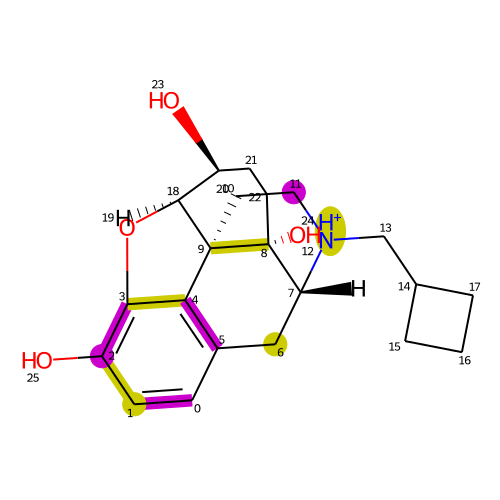

In [17]:
from IPython.display import SVG
smi = bart.decode(smiles[0])
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts("C")
hit_ats = [1,2,6,11,12]
hit_bonds = [0, 1, 2, 3, 4, 8]
IPythonConsole.molSize = 500,500
show_atom_number(mol, 'atomNote')

colours = [(0.8,0.0,0.8),(0.8,0.8,0)]
atom_cols = {}
for i, at in enumerate(hit_ats):
    atom_cols[at] = colours[(i%2+1)%2]
bond_cols = {}
for i, bd in enumerate(hit_bonds):
    bond_cols[bd] = colours[i%2]

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, 
                                    highlightAtomColors=atom_cols,
                                    highlightBondColors=bond_cols,
                                    highlightBonds=hit_bonds,  
                                    highlightAtoms=hit_ats )
d.FinishDrawing()
SVG(d.GetDrawingText())


In [89]:
# bart.decode(smiles[0])
s = 'c1cc(c2c3c1C[C@@H]4[C@]5([C@]3(CC[NH+]4CC6CCC6)[C@@H](O2)[C@H](CC5)O)O)O'
# bart.decode(torch.tensor([smiles[0][3].item()]))
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
substructure = Chem.MolFromSmarts("c1cc(C(=O)O)c(OC(=O)C)cc1")
print(m.GetSubstructMatches(substructure))
print(Chem.MolToSmiles(m))
atoms = []
for i in m.GetAtoms():
    atoms.append(i.GetSymbol())
atoms, m.FinishDrawing()
SVG(d.GetDrawingText())



((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),)
CC(=O)Oc1ccccc1C(=O)O


AttributeError: 'Mol' object has no attribute 'FinishDrawing'

In [103]:
# for i in Chem.MolFromSmiles(s).GetAtoms():
#     print(i.GetSymbol())



tensor([ 63,   9,   6,  19,   7,   9,  13,   9,  27,   9,   6,   4,  11,   4,
         16,  10, 292,   4, 499,  11,   4, 157,   4,   4,  11,  14,  10, 357,
         55,   4,   4, 319,   4,   4,   4, 654,   4,  16,  10,  17,   8,  24,
         11,   4,  15,  10,  17,   4,   4, 224,   8,   5,   8,   5,   8,   2])

In [71]:

IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
        
    return mol

ccccccCCHCCCCNHCCCCCCHOCHCCOOO
((12,),)


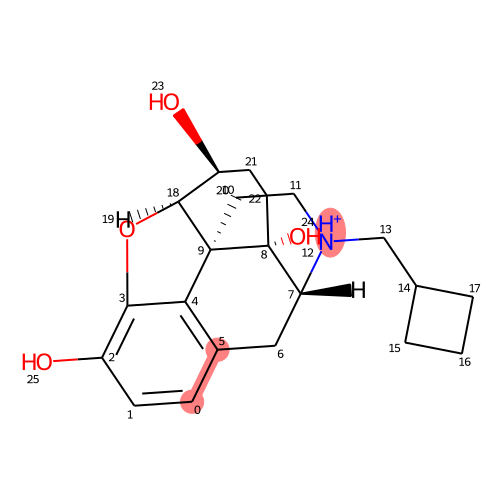

In [110]:
mol = Chem.MolFromSmiles(bart.decode(smiles[0]))
# Default
s = bart.decode(smiles[0])
# s.isidentifier()
s = ''.join([i for i in s if i.isidentifier()])
print(s)
show_atom_number(mol, 'atomNote')

substructure = Chem.MolFromSmarts('N')
print(m.GetSubstructMatches(substructure))


mol.__sssAtoms = [0,12,5]
mol

In [113]:

for ind in range(len(smiles[0])):

    print(bart.decode(torch.tensor([smiles[0][ind]])))




c
1
cc
(
c
2
c
3
c
1
C
[
C
@@
H
]4[
C
@]5(
[
C
@]3(
C
C
[
N
H
+]
4
C
C
6
C
C
C
6)[
C
@@
H
](
O
2)
[
C
@
H
](
C
C
5)
O
)
O
)
O



In [121]:
attributions_list

[]

In [23]:
attributions_map_rgb = []
for att in attributions_list:
    map_0to255 = [(int(i*256),0,0) if i >= 0 else (0, 0, (-1)*int(i*256)) for i in att[1:-1]]
    attributions_map_rgb.append(map_0to255)
# attributions_map_rgb[0]


In [24]:
sm_token = []
for smile in smiles:
    l = []
    for sm_ind in range(len(smile)):

        l.append(bart.decode(torch.tensor([smile[sm_ind]])))
    sm_token.append(l)
# sm_token[0]


In [25]:
len(sm_token[0])

56

In [91]:
m = Chem.MolFromSmiles(s)
substructure = Chem.MolFromSmarts('CCC')
print(m.GetSubstructMatches(substructure))

((6, 7, 8), (7, 8, 9), (7, 8, 22), (8, 9, 10), (8, 9, 18), (8, 22, 21), (9, 8, 22), (9, 10, 11), (9, 18, 20), (10, 9, 18), (13, 14, 15), (13, 14, 17), (14, 15, 16), (14, 17, 16), (15, 14, 17), (15, 16, 17), (18, 20, 21), (20, 21, 22))


In [90]:
# print(s)
# m

In [117]:
len(smiles[0]), len(attributions_list[0])

IndexError: list index out of range